In [1]:
import pandas as pd
import os
import sys
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import shutil
from osgeo import ogr
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator


sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws, delete_items
from scripts.utils.cal_crai_calculations import calculate_equal_weighted_index, add_census_tracts
from scripts.utils.cal_crai_plotting import index_plot, plot_region_domain, plot_hazard_score, modular_plot

In [2]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/calcrai_score'
output_folder = 'cal_crai_score_file'

pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/calcrai_score.


In [3]:
calcrai_score = pd.read_csv(r'cal_crai_score_file/calcrai_score.csv')

In [4]:
keep_columns = ['GEOID', 'hazard_score', 'calcrai_score']
calcrai_plotting_columns = calcrai_score[keep_columns]

# Ensure all values in GEOID are strings
calcrai_plotting_columns['GEOID'] = calcrai_plotting_columns['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
calcrai_plotting_columns['GEOID'] = calcrai_plotting_columns['GEOID'].str.zfill(calcrai_plotting_columns['GEOID'].str.len().max() + 1)

calcrai_plotting_columns['hazard_score'] = 1 - calcrai_plotting_columns['hazard_score']

# Display the dataframe
calcrai_plotting_columns

C:\Users\jesse\AppData\Local\Temp\ipykernel_25148\2945581013.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calcrai_plotting_columns['GEOID'] = calcrai_plotting_columns['GEOID'].astype(str)
C:\Users\jesse\AppData\Local\Temp\ipykernel_25148\2945581013.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calcrai_plotting_columns['GEOID'] = calcrai_plotting_columns['GEOID'].str.zfill(calcrai_plotting_columns['GEOID'].str.len().max() + 1)
C:\Users\jesse\AppData\Local\Temp\ipykernel_25148\2945581013.py:10: S

GEOID  hazard_score  calcrai_score
0     06001400100      0.308160       0.593840
1     06001400200      0.356588       0.520210
2     06001400300      0.298532       0.384277
3     06001400400      0.356800       0.417900
4     06001400500      0.284675       0.350419
...           ...           ...            ...
9124  06115040902      0.684277       1.320288
9125  06115041001      0.705414       1.037047
9126  06115041002      0.694461       1.342894
9127  06115041101      0.721491       1.337257
9128  06115041102      0.698097       1.235337

[9129 rows x 3 columns]

In [5]:
# Binning into quartiles
binned_equal_df = calcrai_plotting_columns.copy()

# Define the columns to bin
columns_to_bin = [
    'calcrai_score'
]

# Apply qcut to each specified column and print the bin edges
for column in columns_to_bin:
    # Get the bin labels and edges
    binned_equal_df[column + '_quartile'], bin_edges = pd.qcut(
        binned_equal_df[column], 
        q=[0,0.2, 0.4, 0.6, 0.8, 1.0], 
        labels=False,
        # labels=['<20%', '20-40%', '40-60%', '60-80%', '>80%'],
        duplicates='drop', 
        retbins=True
    )
    print(f'Bin edges for {column}: {bin_edges}')

# Show the resulting DataFrame with the binned columns
binned_equal_df = binned_equal_df[['GEOID','calcrai_score_quartile']]
binned_equal_df

Bin edges for calcrai_score: [0.         0.50782468 0.68969808 1.17630724 1.82769235 4.98642604]


GEOID  calcrai_score_quartile
0     06001400100                       1
1     06001400200                       1
2     06001400300                       0
3     06001400400                       0
4     06001400500                       0
...           ...                     ...
9124  06115040902                       3
9125  06115041001                       2
9126  06115041002                       3
9127  06115041101                       3
9128  06115041102                       3

[9129 rows x 2 columns]

In [6]:
# Create a copy and chain the .replace() calls
binned_df_viz = binned_equal_df.copy()
binned_df_viz['calcrai_score_quartile'] = (
    binned_df_viz['calcrai_score_quartile']
    .replace(0, '0-20%')
    .replace(1, '20-40%')
    .replace(2, '40-60%')
    .replace(3, '60-80%')
    .replace(4, '80+%')
)
binned_df_viz.head()

GEOID calcrai_score_quartile
0  06001400100                 20-40%
1  06001400200                 20-40%
2  06001400300                  0-20%
3  06001400400                  0-20%
4  06001400500                  0-20%

In [7]:
merged_df = pd.merge(calcrai_plotting_columns, binned_df_viz, on='GEOID', how='left')
merged_df

GEOID  hazard_score  calcrai_score calcrai_score_quartile
0     06001400100      0.308160       0.593840                 20-40%
1     06001400200      0.356588       0.520210                 20-40%
2     06001400300      0.298532       0.384277                  0-20%
3     06001400400      0.356800       0.417900                  0-20%
4     06001400500      0.284675       0.350419                  0-20%
...           ...           ...            ...                    ...
9124  06115040902      0.684277       1.320288                 60-80%
9125  06115041001      0.705414       1.037047                 40-60%
9126  06115041002      0.694461       1.342894                 60-80%
9127  06115041101      0.721491       1.337257                 60-80%
9128  06115041102      0.698097       1.235337                 60-80%

[9129 rows x 4 columns]

In [8]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from shapely.geometry import box # type: ignore

census_shp_dir = "s3://ca-climate-index/0_map_data/2021_tiger_census_tract/2021_ca_tract/"
ca_boundaries = gpd.read_file(census_shp_dir)
ca_boundaries['GEOID'] = ca_boundaries['GEOID'].astype(str)

In [9]:
# Merge the passed DataFrame with the census boundary data
merged_df = merged_df.merge(ca_boundaries, on='GEOID')
merged_df['geometry'] = merged_df['geometry']
merged_df = gpd.GeoDataFrame(merged_df, geometry='geometry', crs=4269)

In [10]:
la_county = merged_df[merged_df['COUNTYFP'] =='037']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


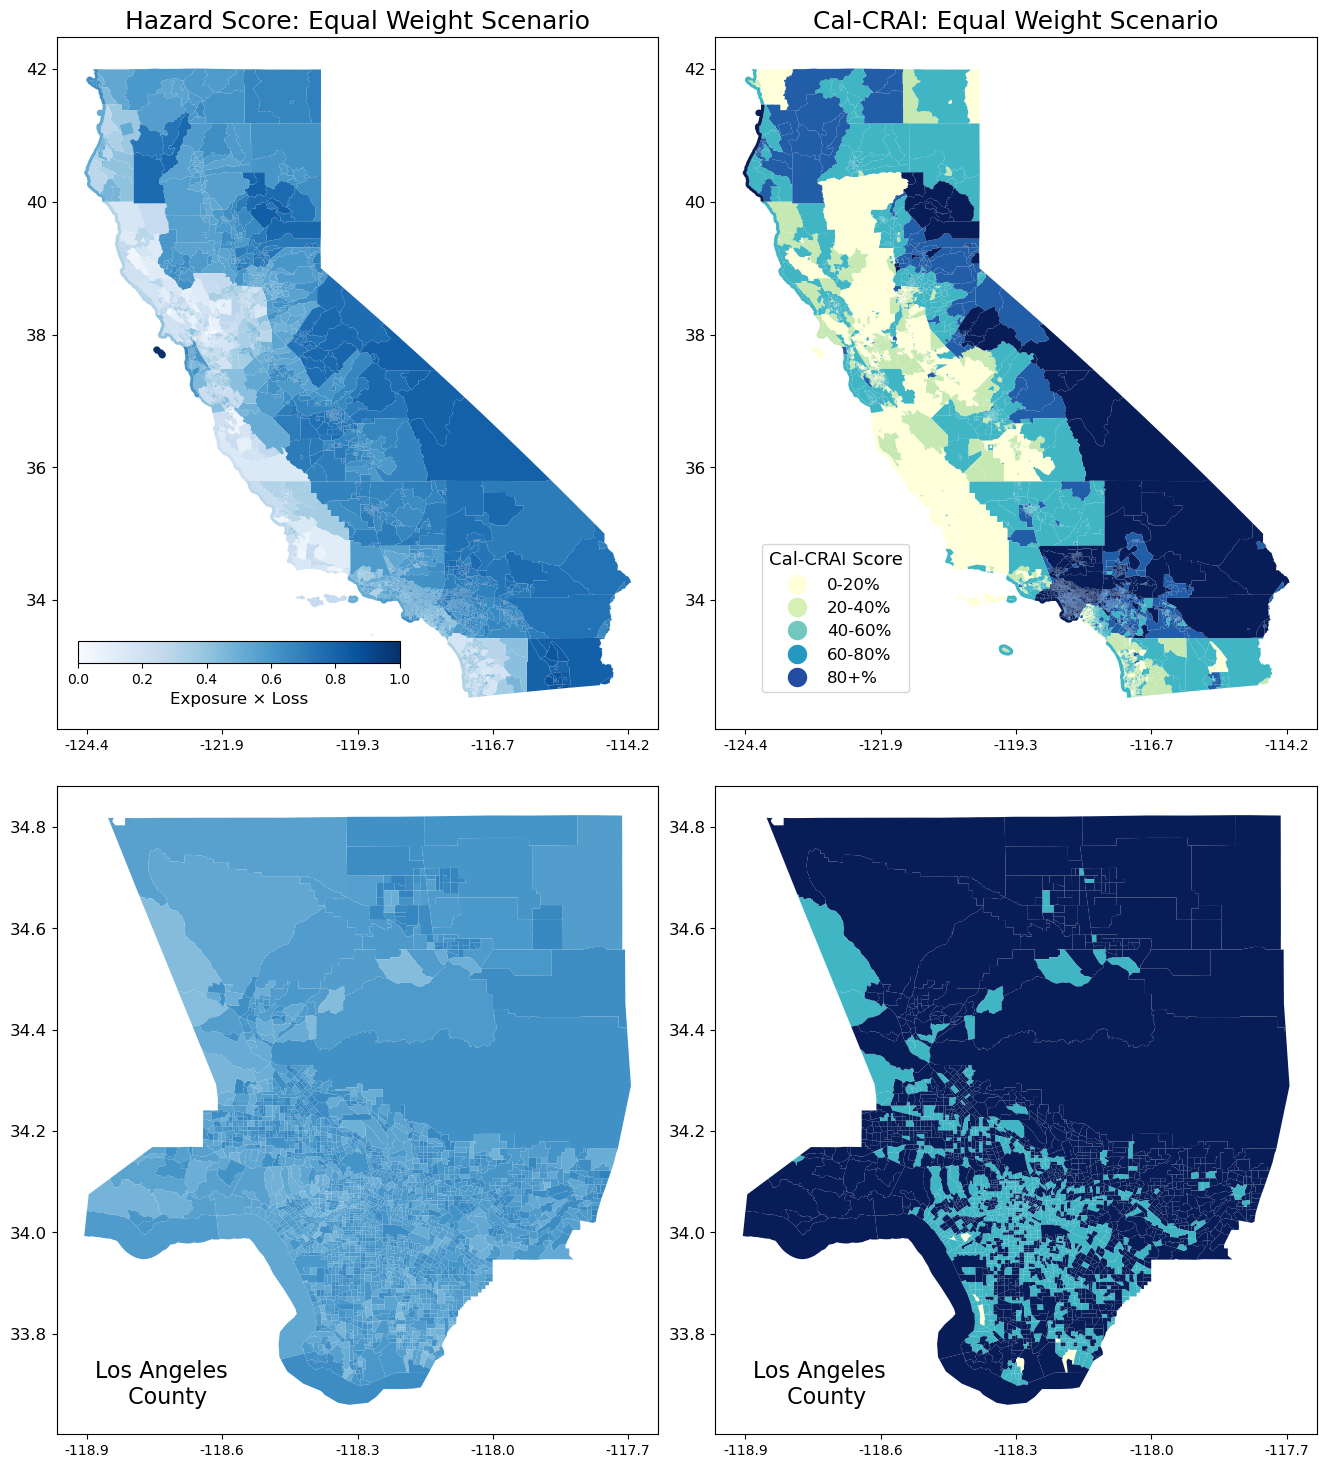

In [66]:
fig = plt.figure(figsize=(14, 22))
gs = plt.GridSpec(2, 2, height_ratios=[1, 1], wspace=0.095, hspace=-0.42)

# Top-left subplot (hazard score)
ax0 = fig.add_subplot(gs[0, 0])
modular_plot(merged_df, 
             column='hazard_score', 
             plot_title='Hazard Score: Equal Weight Scenario', 
             x_ticks=5, 
             ax=ax0, 
             cmap='Blues', 
             vmin=0, 
             vmax=1, 
             set_legend=False)

cbar_ax = fig.add_axes([0.065, 0.5381, 0.23, 0.01])
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []  # Required for the ScalarMappable
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label(u'Exposure \u00D7 Loss', fontsize=12)

# Top-right subplot (index plot)
ax1 = fig.add_subplot(gs[0, 1])
modular_plot(merged_df, 
             column='calcrai_score_quartile', 
             plot_title='Cal-CRAI: Equal Weight Scenario', 
             ax=ax1, 
             cmap='YlGnBu', 
             categorical=True, 
             set_legend=True, 
             legend_position='center', 
             legend_bbox=(0.2, 0.16), 
             x_ticks=5)

# Manually add legend if not automatically generated
handles, labels = ax1.get_legend_handles_labels()
if not labels:  # If no labels detected, add manually
    #unique_values = merged_df['calcrai_score_quartile'].unique()
    unique_values = sorted(merged_df['calcrai_score_quartile'].dropna().unique())  

    handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(val),
                          markerfacecolor=plt.cm.YlGnBu(i/len(unique_values)), markersize=15)
               for i, val in enumerate(unique_values)]
    ax1.legend(handles=handles, title="Cal-CRAI Score", fontsize=12, title_fontsize=13, loc='center', bbox_to_anchor=(0.2, 0.16))

# Bottom-left subplot (LA hazard score)
ax2 = fig.add_subplot(gs[1, 0])
modular_plot(la_county, 
             column='hazard_score', 
             ax=ax2, 
             cmap='Blues', 
             vmin=0, 
             vmax=1, 
             set_legend=False, 
             x_ticks=5, 
             custom_text='Los Angeles \n County', 
             font_color='black')

# Bottom-right subplot (LA index plot)
ax3 = fig.add_subplot(gs[1, 1])
modular_plot(la_county, 
             column='calcrai_score_quartile', 
             ax=ax3, 
             cmap='YlGnBu', 
             categorical=True, 
             set_legend=False, 
             x_ticks=5, 
             custom_text='Los Angeles \n County', 
             font_color='black')

# Adjust spacing
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# Save the figure
fig.savefig('CalCRAI_subplot.png', dpi=300, bbox_inches='tight')
plt.show()

## Drought

In [13]:
# pull csv from aws
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/calcrai_drought_scenario_index.csv'
output_folder = 'cal_crai_score_file'

pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/calcrai_drought_scenario_index.csv.


In [14]:
drought_weighting = pd.read_csv('cal_crai_score_file/calcrai_drought_scenario_index.csv')

In [15]:
drought_weighting

GEOID  governance_domain_score  built_environment_domain_score  \
0     6001400100                 0.384966                        0.605062   
1     6001400200                 0.384966                        0.553534   
2     6001400300                 0.384966                        0.557473   
3     6001400400                 0.384966                        0.549355   
4     6001400500                 0.384966                        0.552923   
...          ...                      ...                             ...   
9124  6115040902                 0.506516                        0.468943   
9125  6115041001                 0.455906                        0.416459   
9126  6115041002                 0.541790                        0.432561   
9127  6115041101                 0.503268                        0.391202   
9128  6115041102                 0.478910                        0.474918   

      natural_systems_domain_score  society_economy_domain_score  \
0                         0.589375                      0.833488   
1                         0.514427                      0.841855   
2                         0.450082                      0.793298   
3                         0.474044                      0.770451   
4                         0.463199                      0.744977   
...                            ...                           ...   
9124                      0.609509                      0.783342   
9125                      0.599682                      0.742681   
9126                      0.616996                      0.766956   
9127                      0.668231                      0.736324   
9128                      0.605114                      0.748923   

      built_environment_median  natural_systems_median  \
0                     0.642475                0.582181   
1                     0.642475                0.582181   
2                     0.642475                0.582181   
3                     0.642475                0.582181   
4                     0.642475                0.582181   
...                        ...                     ...   
9124                  0.642475                0.582181   
9125                  0.642475                0.582181   
9126                  0.642475                0.582181   
9127                  0.642475                0.582181   
9128                  0.642475                0.582181   

      society_economy_median  natural_systems_tract_adjusted  \
0                   0.748805                        0.012357   
1                   0.748805                       -0.116380   
2                   0.748805                       -0.226903   
3                   0.748805                       -0.185744   
4                   0.748805                       -0.204372   
...                      ...                             ...   
9124                0.748805                        0.046941   
9125                0.748805                        0.030061   
9126                0.748805                        0.059802   
9127                0.748805                        0.147807   
9128                0.748805                        0.039392   

      society_economy_tract_adjusted  built_environment_tract_adjusted  \
0                           0.113091                         -0.058232   
1                           0.124264                         -0.138434   
2                           0.059419                         -0.132304   
3                           0.028908                         -0.144939   
4                          -0.005111                         -0.139386   
...                              ...                               ...   
9124                        0.046124                         -0.270099   
9125                       -0.008179                         -0.351789   
9126                        0.024240                         -0.326726   
9127                       -0.016668                         -0

In [16]:
keep_columns = ['GEOID', 'drought_hazard_score', 'drought_scenario_calcrai_score']
calcrai_drought_plotting_columns = drought_weighting[keep_columns]

# Ensure all values in GEOID are strings
calcrai_drought_plotting_columns['GEOID'] = calcrai_drought_plotting_columns['GEOID'].astype(str)

# Add a '0' to the beginning of each GEOID and pad them to the correct length
calcrai_drought_plotting_columns['GEOID'] = calcrai_drought_plotting_columns['GEOID'].str.zfill(calcrai_drought_plotting_columns['GEOID'].str.len().max() + 1)

calcrai_drought_plotting_columns['drought_hazard_score'] = 1 - calcrai_drought_plotting_columns['drought_hazard_score']

# Display the dataframe
calcrai_drought_plotting_columns

C:\Users\jesse\AppData\Local\Temp\ipykernel_25148\3877455671.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calcrai_drought_plotting_columns['GEOID'] = calcrai_drought_plotting_columns['GEOID'].astype(str)
C:\Users\jesse\AppData\Local\Temp\ipykernel_25148\3877455671.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calcrai_drought_plotting_columns['GEOID'] = calcrai_drought_plotting_columns['GEOID'].str.zfill(calcrai_drought_plotting_columns['GEOID'].str.len().max() + 1)
C:\Users\jesse\AppData\Local\

GEOID  drought_hazard_score  drought_scenario_calcrai_score
0     06001400100              0.121768                        0.457367
1     06001400200              0.121768                        0.416282
2     06001400300              0.147216                        0.395974
3     06001400400              0.147216                        0.382749
4     06001400500              0.147216                        0.370311
...           ...                   ...                             ...
9124  06115040902              0.675200                        1.235830
9125  06115041001              0.688042                        0.972087
9126  06115041002              0.677340                        1.213633
9127  06115041101              0.646662                        0.919153
9128  06115041102              0.649516                        1.039367

[9129 rows x 3 columns]

In [17]:
# Binning into quartiles
binned_drought_df = calcrai_drought_plotting_columns.copy()

# Define the columns to bin
columns_to_bin = [
    'drought_scenario_calcrai_score'
]

# Apply qcut to each specified column and print the bin edges
for column in columns_to_bin:
    # Get the bin labels and edges
    binned_drought_df[column + '_quartile'], bin_edges = pd.qcut(
        binned_drought_df[column], 
        q=[0,0.2, 0.4, 0.6, 0.8, 1.0], 
        labels=False,
        # labels=['<20%', '20-40%', '40-60%', '60-80%', '>80%'],
        duplicates='drop', 
        retbins=True
    )
    print(f'Bin edges for {column}: {bin_edges}')

# Show the resulting DataFrame with the binned columns
binned_drought_df = binned_drought_df[['GEOID','drought_scenario_calcrai_score_quartile']]
binned_drought_df

Bin edges for drought_scenario_calcrai_score: [ 0.          0.52652309  1.02915265  1.60722415  2.11176125 21.93983521]


GEOID  drought_scenario_calcrai_score_quartile
0     06001400100                                        0
1     06001400200                                        0
2     06001400300                                        0
3     06001400400                                        0
4     06001400500                                        0
...           ...                                      ...
9124  06115040902                                        2
9125  06115041001                                        1
9126  06115041002                                        2
9127  06115041101                                        1
9128  06115041102                                        2

[9129 rows x 2 columns]

In [18]:
# Create a copy and chain the .replace() calls
binned_drought_df_viz = binned_drought_df.copy()
binned_drought_df_viz['calcrai_drought_score_quartile'] = (
    binned_drought_df_viz['drought_scenario_calcrai_score_quartile']
    .replace(0, '0-20%')
    .replace(1, '20-40%')
    .replace(2, '40-60%')
    .replace(3, '60-80%')
    .replace(4, '80+%')
)
binned_drought_df_viz.tail()

GEOID  drought_scenario_calcrai_score_quartile  \
9124  06115040902                                        2   
9125  06115041001                                        1   
9126  06115041002                                        2   
9127  06115041101                                        1   
9128  06115041102                                        2   

     calcrai_drought_score_quartile  
9124                         40-60%  
9125                         20-40%  
9126                         40-60%  
9127                         20-40%  
9128                         40-60%

In [19]:
merged_drought_df = pd.merge(calcrai_drought_plotting_columns, binned_drought_df_viz, on='GEOID', how='left')
merged_drought_df

GEOID  drought_hazard_score  drought_scenario_calcrai_score  \
0     06001400100              0.121768                        0.457367   
1     06001400200              0.121768                        0.416282   
2     06001400300              0.147216                        0.395974   
3     06001400400              0.147216                        0.382749   
4     06001400500              0.147216                        0.370311   
...           ...                   ...                             ...   
9124  06115040902              0.675200                        1.235830   
9125  06115041001              0.688042                        0.972087   
9126  06115041002              0.677340                        1.213633   
9127  06115041101              0.646662                        0.919153   
9128  06115041102              0.649516                        1.039367   

      drought_scenario_calcrai_score_quartile calcrai_drought_score_quartile  
0                                           0                          0-20%  
1                                           0                          0-20%  
2                                           0                          0-20%  
3                                           0                          0-20%  
4                                           0                          0-20%  
...                                       ...                            ...  
9124                                        2                         40-60%  
9125                                        1                         20-40%  
9126                                        2                         40-60%  
9127                                        1                         20-40%  
9128                                        2                         40-60%  

[9129 rows x 5 columns]

In [20]:
# Merge the passed DataFrame with the census boundary data
merged_drought_df_ca_boundries = merged_drought_df.merge(ca_boundaries, on='GEOID')
merged_drought_df_ca_boundries['geometry'] = merged_drought_df_ca_boundries['geometry']
merged_drought_df_ca_boundries = gpd.GeoDataFrame(merged_drought_df_ca_boundries, geometry='geometry', crs=4269)

In [21]:
merged_drought_df_ca_boundries

GEOID  drought_hazard_score  drought_scenario_calcrai_score  \
0     06001400100              0.121768                        0.457367   
1     06001400200              0.121768                        0.416282   
2     06001400300              0.147216                        0.395974   
3     06001400400              0.147216                        0.382749   
4     06001400500              0.147216                        0.370311   
...           ...                   ...                             ...   
9124  06115040902              0.675200                        1.235830   
9125  06115041001              0.688042                        0.972087   
9126  06115041002              0.677340                        1.213633   
9127  06115041101              0.646662                        0.919153   
9128  06115041102              0.649516                        1.039367   

      drought_scenario_calcrai_score_quartile calcrai_drought_score_quartile  \
0                                           0                          0-20%   
1                                           0                          0-20%   
2                                           0                          0-20%   
3                                           0                          0-20%   
4                                           0                          0-20%   
...                                       ...                            ...   
9124                                        2                         40-60%   
9125                                        1                         20-40%   
9126                                        2                         40-60%   
9127                                        1                         20-40%   
9128                                        2                         40-60%   

     STATEFP COUNTYFP TRACTCE    NAME             NAMELSAD  MTFCC FUNCSTAT  \
0         06      001  400100    4001    Census Tract 4001  G5020        S   
1         06      001  400200    4002    Census Tract 4002  G5020        S   
2         06      001  400300    4003    Census Tract 4003  G5020        S   
3         06      001  400400    4004    Census Tract 4004  G5020        S   
4         06      001  400500    4005    Census Tract 4005  G5020        S   
...      ...      ...     ...     ...                  ...    ...      ...   
9124      06      115  040902  409.02  Census Tract 409.02  G5020        S   
9125      06      115  041001  410.01  Census Tract 410.01  G5020        S   
9126      06      115  041002  410.02  Census Tract 410.02  G5020        S   
9127      06      115  041101  411.01  Census Tract 411.01  G5020        S   
9128      06      115  041102  411.02  Census Tract 411.02  G5020        S   

          ALAND    AWATER     INTPTLAT      INTPTLON  \
0       6945856         0  +37.8676563  -122.2318813   
1        586560         0  +37.8481378  -122.2495916   
2       1110840         0  +37.8405841  -122.2544782   
3        716138         0  +37.8482840  -122.2574447   
4        591424         0  +37.8485452  -122.2647353   
...         ...       ...          ...           ...   
9124   93603063    240059  +39.1193450  -121.3995842   
9125  275920634   1720985  +39.2634436  -121.5062545   
9126  192476772   5206412  +39.2923343  -121.3205968   
9127  464905359  16529900  +39.4752686  -121.1718725   
9128   94410923    550493  +39.3656565  -121.2369173   

                                               geometry  
0     POLYGON ((-122.24691 37.88535, -122.24665 37.8...  
1     POLYGON ((-122.25792 37.84261, -122.25773 37.8...  
2     POLYGON ((-122.26563 37.83764, -122.26556 37.8...  
3     POLYGON ((-122.26183 37.84162, -122.26180 37.8...  
4     POLYGON ((-122.26951 37.84858, -122.26937 37.8...  
...                                                 ...  
9124  POLYGON ((-121.47722 39.13333, -121.47709 39.1...  
9125  POLYGON ((-121.63637 39.24608, -121.63629 39.2...  
9126  POLYGON ((-1

In [22]:
la_county_drought = merged_drought_df_ca_boundries[merged_drought_df_ca_boundries['COUNTYFP'] =='037']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


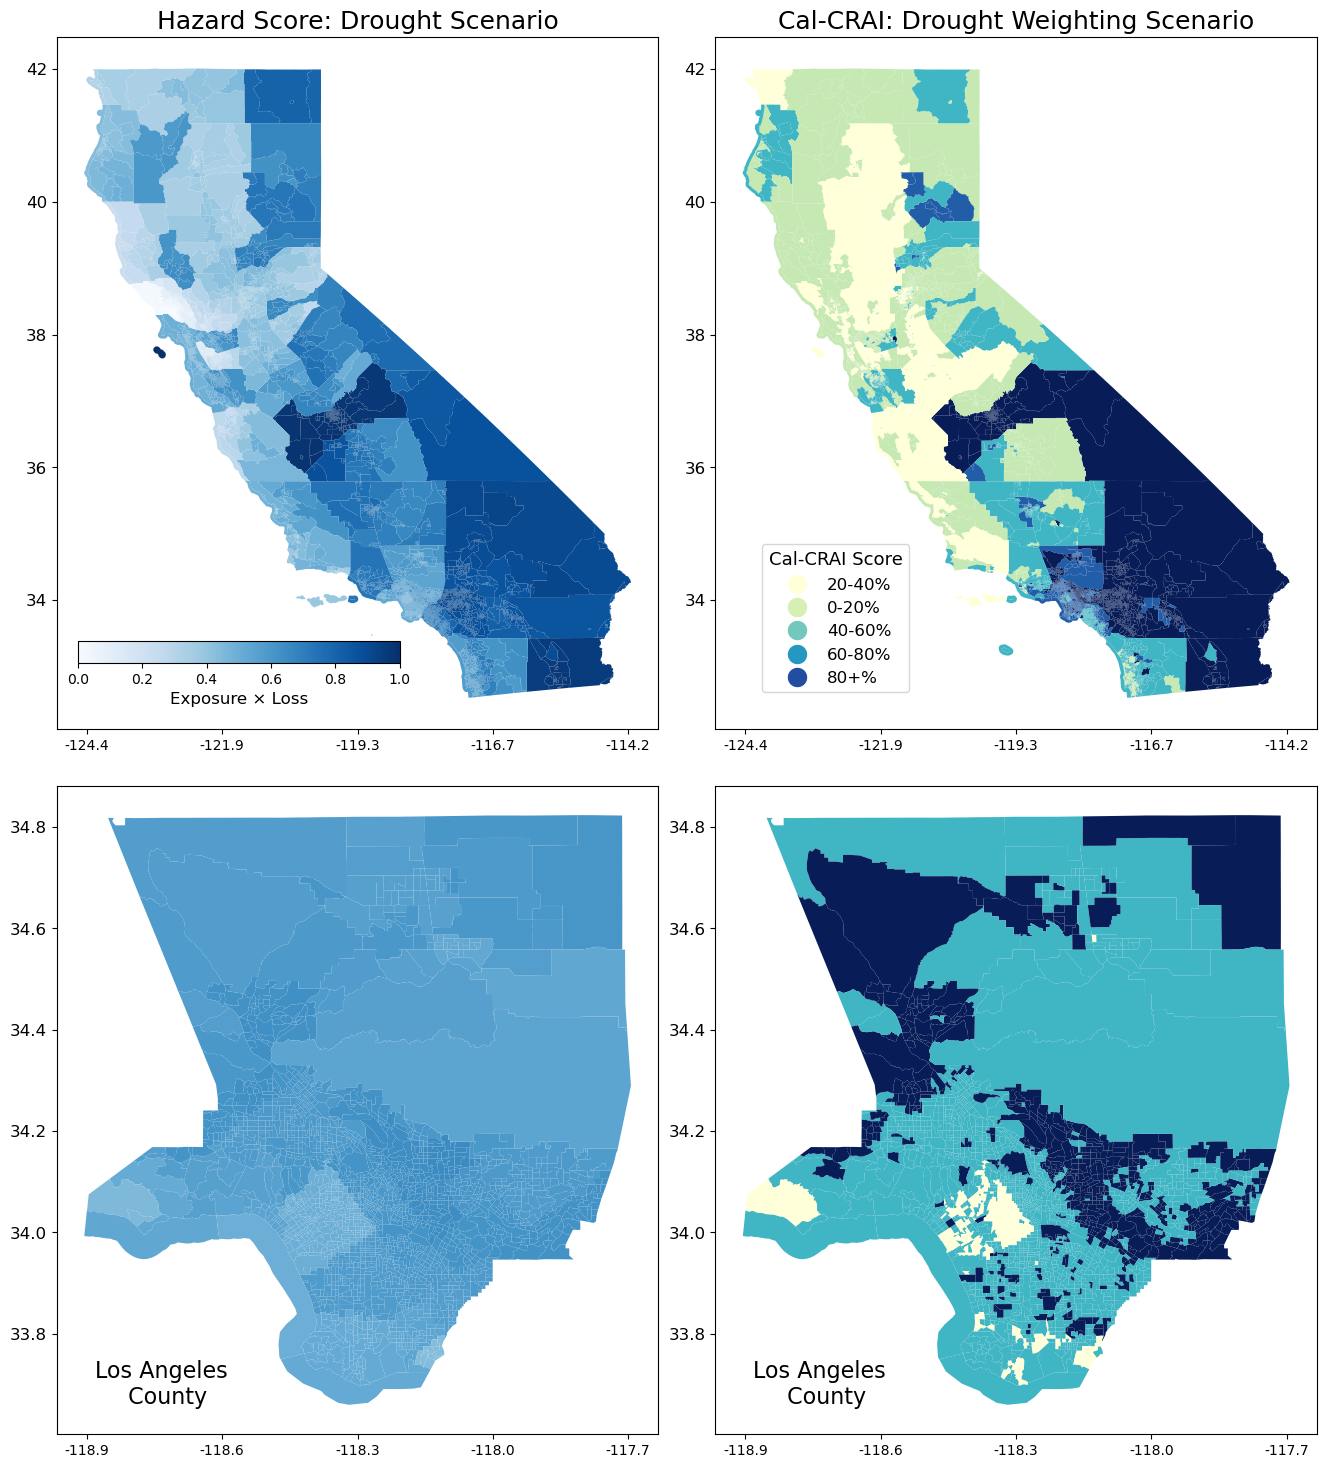

In [23]:
fig = plt.figure(figsize=(14, 22))
gs = plt.GridSpec(2, 2, height_ratios=[1, 1], wspace=0.095, hspace=-0.42)

# Top-left subplot (hazard score)
ax0 = fig.add_subplot(gs[0, 0])
modular_plot(merged_drought_df_ca_boundries, 
             column='drought_hazard_score', 
             plot_title='Hazard Score: Drought Scenario', 
             x_ticks=5, 
             ax=ax0, 
             cmap='Blues', 
             vmin=0, 
             vmax=1, 
             set_legend=False)

cbar_ax = fig.add_axes([0.065, 0.5381, 0.23, 0.01])
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=1))
sm._A = []  # Required for the ScalarMappable
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label(u'Exposure \u00D7 Loss', fontsize=12)

# Top-right subplot (index plot)
ax1 = fig.add_subplot(gs[0, 1])
modular_plot(merged_drought_df_ca_boundries, 
             column='calcrai_drought_score_quartile', 
             plot_title='Cal-CRAI: Drought Weighting Scenario', 
             ax=ax1, 
             cmap='YlGnBu', 
             categorical=True, 
             set_legend=True, 
             legend_position='center', 
             legend_bbox=(0.2, 0.16), 
             x_ticks=5)

# Manually add legend if not automatically generated
handles, labels = ax1.get_legend_handles_labels()
if not labels:  # If no labels detected, add manually
    unique_values = merged_df['calcrai_score_quartile'].unique()
    handles = [plt.Line2D([0], [0], marker='o', color='w', label=str(val),
                          markerfacecolor=plt.cm.YlGnBu(i/len(unique_values)), markersize=15)
               for i, val in enumerate(unique_values)]
    ax1.legend(handles=handles, title="Cal-CRAI Score", fontsize=12, title_fontsize=13, loc='center', bbox_to_anchor=(0.2, 0.16))

# Bottom-left subplot (LA hazard score)
ax2 = fig.add_subplot(gs[1, 0])
modular_plot(la_county_drought, 
             column='drought_hazard_score', 
             ax=ax2, 
             cmap='Blues', 
             vmin=0, 
             vmax=1, 
             set_legend=False, 
             x_ticks=5, 
             custom_text='Los Angeles \n County', 
             font_color='black')

# Bottom-right subplot (LA index plot)
ax3 = fig.add_subplot(gs[1, 1])
modular_plot(la_county_drought, 
             column='calcrai_drought_score_quartile', 
             ax=ax3, 
             cmap='YlGnBu', 
             categorical=True, 
             set_legend=False, 
             x_ticks=5, 
             custom_text='Los Angeles \n County', 
             font_color='black')

# Adjust spacing
fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)

# Save the figure
fig.savefig('CalCRAI_drought_subplot.png', dpi=300, bbox_inches='tight')
plt.show()


## All the other Climate Risk Scenarios

In [26]:
weighted_index_names = ['calcrai_heat_scenario_index',
                        'calcrai_inland_flooding_scenario_index', 
                        'calcrai_sea_level_rise_scenario_index',
                        'calcrai_wildfire_scenario_index']

# pull csv from aws
for risk in weighted_index_names:
    bucket_name = 'ca-climate-index'
    aws_dir = f'3_fair_data/index_data/{risk}.csv'
    output_folder = 'cal_crai_weighted_score_file'

    pull_csv_from_directory(bucket_name, aws_dir, output_folder, search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/calcrai_heat_scenario_index.csv.
Metric data retrieved from 3_fair_data/index_data/calcrai_inland_flooding_scenario_index.csv.
Metric data retrieved from 3_fair_data/index_data/calcrai_sea_level_rise_scenario_index.csv.
Metric data retrieved from 3_fair_data/index_data/calcrai_wildfire_scenario_index.csv.


In [40]:
extreme_heat_weighting = pd.read_csv('cal_crai_weighted_score_file/calcrai_heat_scenario_index.csv')
inland_flooding_weighting = pd.read_csv('cal_crai_weighted_score_file/calcrai_inland_flooding_scenario_index.csv')
sea_level_rise_weighting = pd.read_csv('cal_crai_weighted_score_file/calcrai_sea_level_rise_scenario_index.csv')
wildfire_weighting = pd.read_csv('cal_crai_weighted_score_file/calcrai_wildfire_scenario_index.csv')

In [41]:
sea_level_rise_weighting.columns

Index(['GEOID', 'governance_domain_score', 'built_environment_domain_score',
       'natural_systems_domain_score', 'society_economy_domain_score',
       'built_environment_median', 'natural_systems_median',
       'society_economy_median', 'natural_systems_tract_adjusted',
       'society_economy_tract_adjusted', 'built_environment_tract_adjusted',
       'hazard_score', 'drought_hazard_score', 'extreme_heat_hazard_score',
       'inland_flooding_hazard_score', 'sea_level_rise_hazard_score',
       'wildfire_hazard_score', 'weighted_community_capacity',
       'sea_level_rise_scenario_calcrai_score'],
      dtype='object')

In [42]:
def process_weighting_dataframe(df, hazard_type):
    """
    Processes a weighting dataframe by:
    - Keeping relevant columns
    - Converting GEOID to string and padding it
    - Adjusting the hazard score (1 - original score)

    Parameters:
        df (pd.DataFrame): The weighting dataframe.
        hazard_type (str): The hazard type to extract the relevant columns.

    Returns:
        pd.DataFrame: The processed dataframe.
    """
    keep_columns = ['GEOID', f'{hazard_type}_hazard_score', f'{hazard_type}_scenario_calcrai_score']
    
    # Select relevant columns
    df_processed = df[keep_columns].copy()

    # Ensure all values in GEOID are strings
    df_processed['GEOID'] = df_processed['GEOID'].astype(str)

    # Add a '0' to the beginning of each GEOID and pad them to the correct length
    df_processed['GEOID'] = df_processed['GEOID'].str.zfill(df_processed['GEOID'].str.len().max() + 1)

    # Adjust hazard score
    df_processed[f'{hazard_type}_hazard_score'] = 1 - df_processed[f'{hazard_type}_hazard_score']

    return df_processed

# Dictionary of dataframes and their corresponding hazard types
weighting_dfs = {
    "drought": drought_weighting,
    "extreme_heat": extreme_heat_weighting,
    "inland_flooding": inland_flooding_weighting,
    "sea_level_rise": sea_level_rise_weighting,
    "wildfire": wildfire_weighting
}

# Process all dataframes
processed_weighting_dfs = {hazard: process_weighting_dataframe(df, hazard) for hazard, df in weighting_dfs.items()}

# Accessing processed dataframes
calcrai_drought_plotting_columns = processed_weighting_dfs["drought"]
calcrai_heat_plotting_columns = processed_weighting_dfs["extreme_heat"]
calcrai_inland_flooding_plotting_columns = processed_weighting_dfs["inland_flooding"]
calcrai_slr_plotting_columns = processed_weighting_dfs["sea_level_rise"]
calcrai_wildfire_plotting_columns = processed_weighting_dfs["wildfire"]


In [46]:
def process_binning_and_merging(df, hazard_type, ca_boundaries):
    """
    Processes a dataframe by binning the scenario score into quartiles, creating a visualization column, 
    and merging it with California boundary data.

    Parameters:
        df (pd.DataFrame): The processed hazard dataframe.
        hazard_type (str): The hazard type for column naming.
        ca_boundaries (gpd.GeoDataFrame): The geospatial boundary data.

    Returns:
        gpd.GeoDataFrame: The merged geospatial dataframe with binned scores.
    """
    df_binned = df.copy()
    
    # Define the column to bin
    scenario_score_col = f"{hazard_type}_scenario_calcrai_score"
    quartile_col = f"{scenario_score_col}_quartile"
    
    # Apply qcut for binning
    df_binned[quartile_col], bin_edges = pd.qcut(
        df_binned[scenario_score_col], 
        q=[0, 0.2, 0.4, 0.6, 0.8, 1.0], 
        labels=False,
        duplicates='drop', 
        retbins=True
    )
    
    print(f'Bin edges for {hazard_type}: {bin_edges}')

    # Keep only relevant columns
    df_binned = df_binned[['GEOID', quartile_col]]

    # Create a visualization column
    viz_col = f'calcrai_{hazard_type}_score_quartile'
    df_binned[viz_col] = df_binned[quartile_col].replace({
        0: '0-20%', 
        1: '20-40%', 
        2: '40-60%', 
        3: '60-80%', 
        4: '80+%'
    })

    # Merge with original data
    merged_df = pd.merge(df, df_binned, on='GEOID', how='left')

    # Merge with California boundaries
    merged_df_ca_boundaries = merged_df.merge(ca_boundaries, on='GEOID')
    merged_df_ca_boundaries = gpd.GeoDataFrame(
        merged_df_ca_boundaries, 
        geometry='geometry', 
        crs=4269
    )

    # Filter for LA County
    la_county_df = merged_df_ca_boundaries[merged_df_ca_boundaries['COUNTYFP'] == '037']

    return merged_df_ca_boundaries, la_county_df

# Process all hazards
binned_hazard_dfs = {
    hazard: process_binning_and_merging(df, hazard, ca_boundaries) 
    for hazard, df in processed_weighting_dfs.items()
}

# Access specific results
merged_drought_df_ca_boundaries, la_county_drought = binned_hazard_dfs["drought"]
merged_extreme_heat_df_ca_boundaries, la_county_extreme_heat = binned_hazard_dfs["extreme_heat"]
merged_inland_flooding_df_ca_boundaries, la_county_inland_flooding = binned_hazard_dfs["inland_flooding"]
merged_sea_level_rise_df_ca_boundaries, la_county_sea_level_rise = binned_hazard_dfs["sea_level_rise"]
merged_wildfire_df_ca_boundaries, la_county_wildfire = binned_hazard_dfs["wildfire"]


Bin edges for drought: [ 0.          0.52652309  1.02915265  1.60722415  2.11176125 21.93983521]
Bin edges for extreme_heat: [ 0.          0.43231202  0.55420271  0.81664451  1.85020965 38.25046447]
Bin edges for inland_flooding: [0.         0.48791944 0.66975393 0.99902356 1.9646311  6.47946436]
Bin edges for sea_level_rise: [0.         0.79150036 1.27193919 2.80912134 3.82848609 9.81158713]
Bin edges for wildfire: [0.         0.48792844 0.61544646 0.75255759 2.94198934 8.68127605]


In [107]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines

def plot_hazard_subplots(merged_df, la_df, hazard_type, save_path):
    """
    Creates a subplot grid for visualizing hazard scores and Cal-CRAI scores 
    for a given hazard type.

    Parameters:
        merged_df (gpd.GeoDataFrame): The full dataset with hazard and Cal-CRAI scores.
        la_df (gpd.GeoDataFrame): The subset dataset for Los Angeles County.
        hazard_type (str): The hazard type (e.g., 'drought', 'wildfire').
        save_path (str): Path to save the output figure.

    Returns:
        None (saves the figure and displays it).
    """
    fig = plt.figure(figsize=(14, 22))
    #gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], wspace=0.095, hspace=-0.42)
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], wspace=0.095, hspace=-0.32)

    # Top-left subplot (hazard score)
    ax0 = fig.add_subplot(gs[0, 0])
    modular_plot(merged_df, 
                 column=f'{hazard_type}_hazard_score', 
                 plot_title=f'Hazard Score: {hazard_type.replace("_", " ").title()} Scenario',
                 x_ticks=5, 
                 ax=ax0, 
                 cmap='Blues', 
                 vmin=0, 
                 vmax=1, 
                 set_legend=False)

    #cbar_ax = fig.add_axes([0.065, 0.5381, 0.23, 0.01])
    cbar_ax = fig.add_axes([0.065, 0.5181, 0.23, 0.01])
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=1))
    sm._A = []  # Required for ScalarMappable
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(u'Exposure \u00D7 Loss', fontsize=12)

    # Top-right subplot (Cal-CRAI index)
    ax1 = fig.add_subplot(gs[0, 1])
    modular_plot(merged_df, 
                 column=f'calcrai_{hazard_type}_score_quartile', 
                 plot_title=f'Cal-CRAI: {hazard_type.replace("_", " ").title()} Weighting Scenario',
                 ax=ax1, 
                 cmap='YlGnBu', 
                 categorical=True, 
                 set_legend=True, 
                 legend_position='center', 
                 legend_bbox=(0.2, 0.16), 
                 x_ticks=5)

    handles, labels = ax1.get_legend_handles_labels()
    if not labels:  
        unique_values = sorted(merged_df[f'calcrai_{hazard_type}_score_quartile'].dropna().unique())
        handles = [mlines.Line2D([0], [0], marker='o', color='w', label=str(val),
                                 markerfacecolor=plt.cm.YlGnBu(i / len(unique_values)), markersize=15)
                   for i, val in enumerate(unique_values)]
        ax1.legend(handles=handles, title="Cal-CRAI Score", fontsize=12, title_fontsize=13, 
                   loc='center', bbox_to_anchor=(0.2, 0.16))

    # Bottom-left subplot (LA hazard score)
    ax2 = fig.add_subplot(gs[1, 0])
    modular_plot(la_df, 
                 column=f'{hazard_type}_hazard_score', 
                 ax=ax2, 
                 cmap='Blues', 
                 vmin=0, 
                 vmax=1, 
                 set_legend=False, 
                 x_ticks=5, 
                 custom_text='Los Angeles \n County', 
                 font_color='black')

    # Bottom-right subplot (LA Cal-CRAI index)
    ax3 = fig.add_subplot(gs[1, 1])
    modular_plot(la_df, 
                 column=f'calcrai_{hazard_type}_score_quartile', 
                 ax=ax3, 
                 cmap='YlGnBu', 
                 categorical=True, 
                 set_legend=False, 
                 x_ticks=5, 
                 custom_text='Los Angeles \n County', 
                 font_color='black')

    # Adjust spacing and save figure
    fig.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


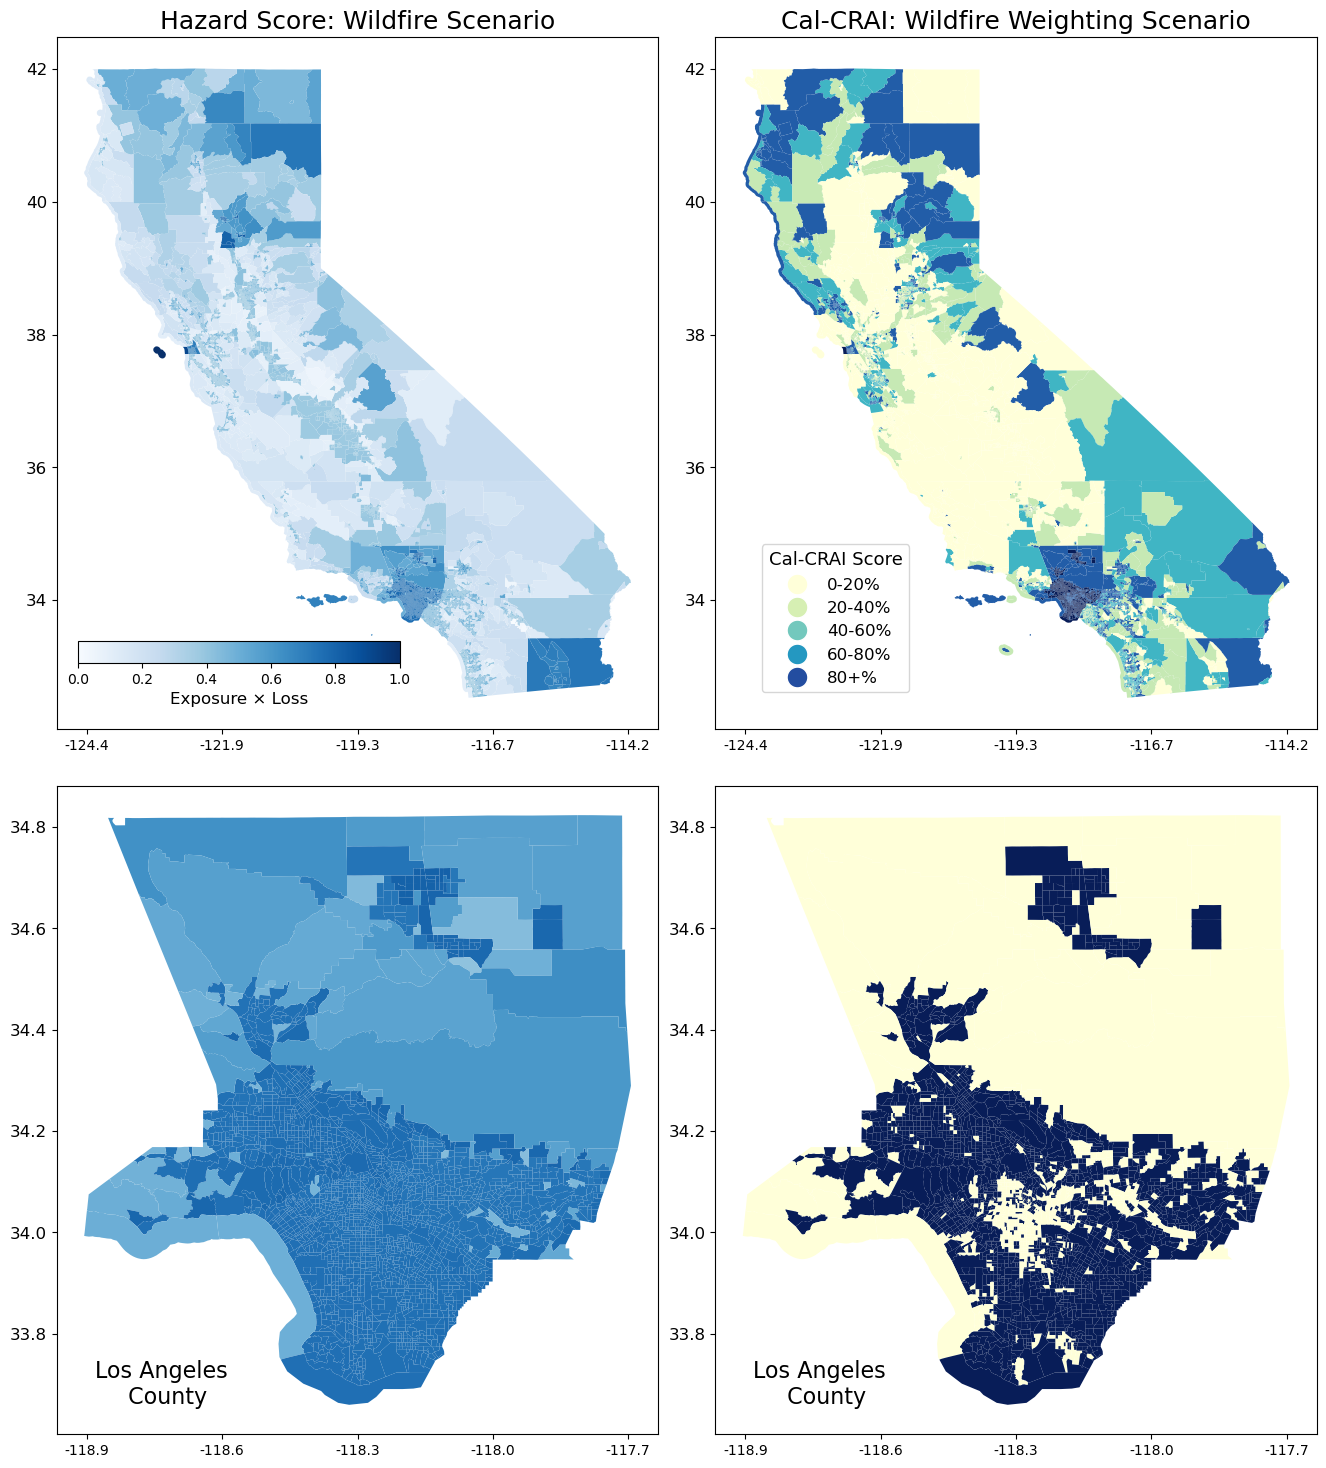

In [70]:
plot_hazard_subplots(merged_wildfire_df_ca_boundaries, la_county_wildfire, 'wildfire', 'CalCRAI_wildfire_subplot.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


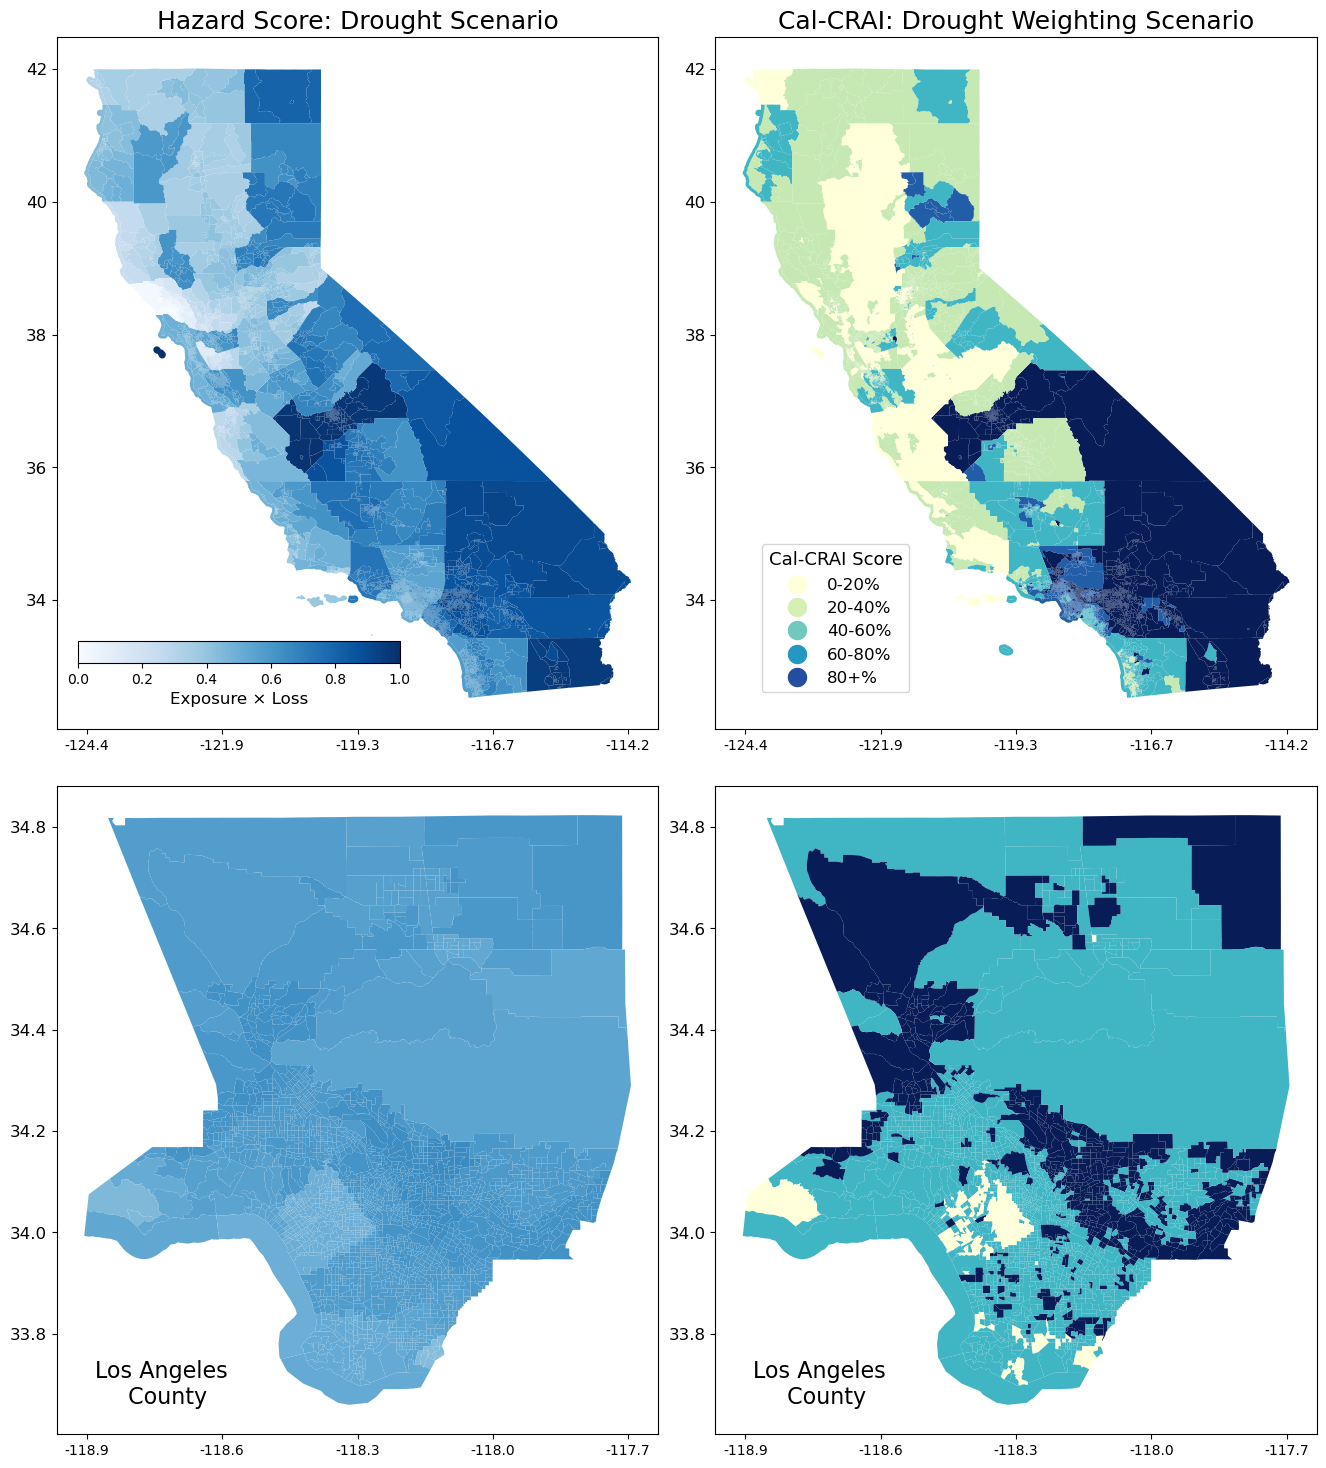

In [71]:
plot_hazard_subplots(merged_drought_df_ca_boundries, la_county_drought, "drought", "CalCRAI_drought_subplot.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


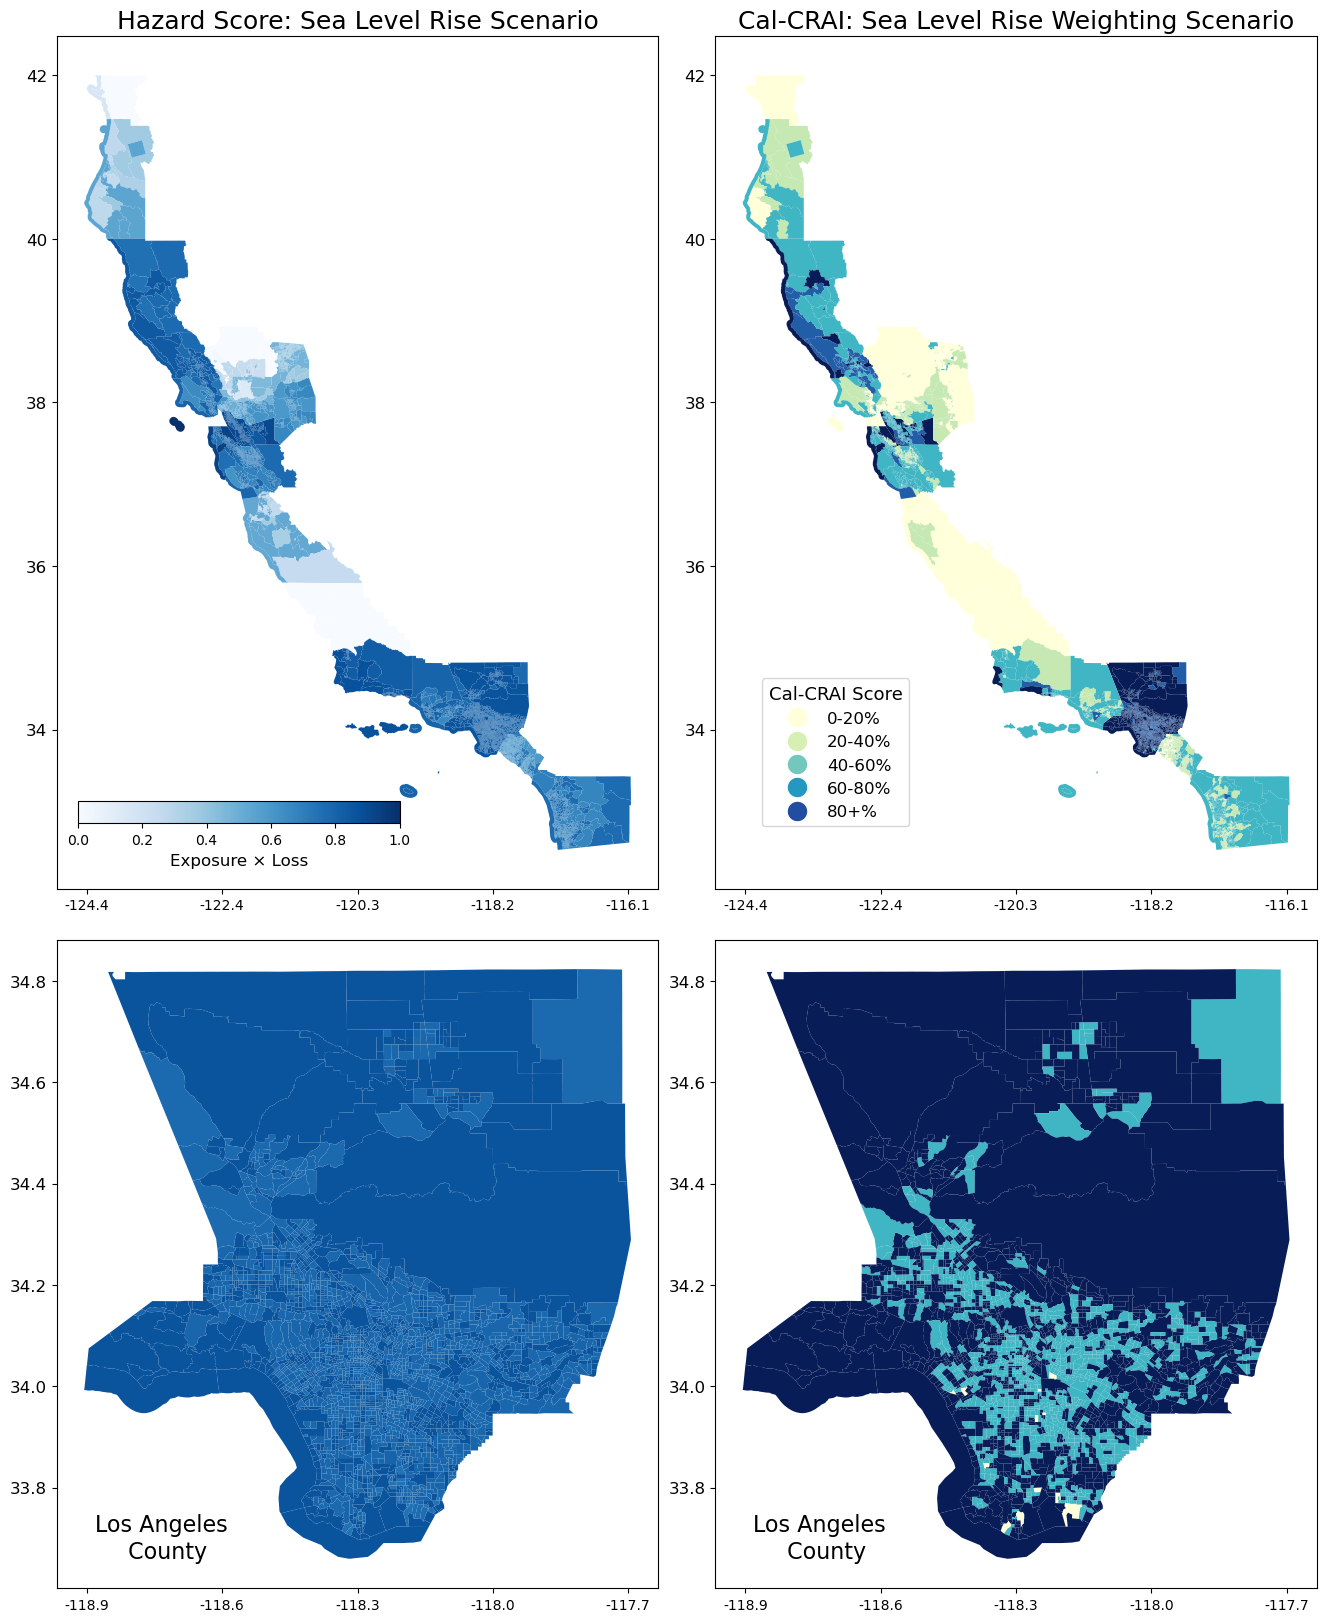

In [108]:
plot_hazard_subplots(merged_sea_level_rise_df_ca_boundaries, la_county_sea_level_rise, "sea_level_rise", "CalCRAI_slr_subplot.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


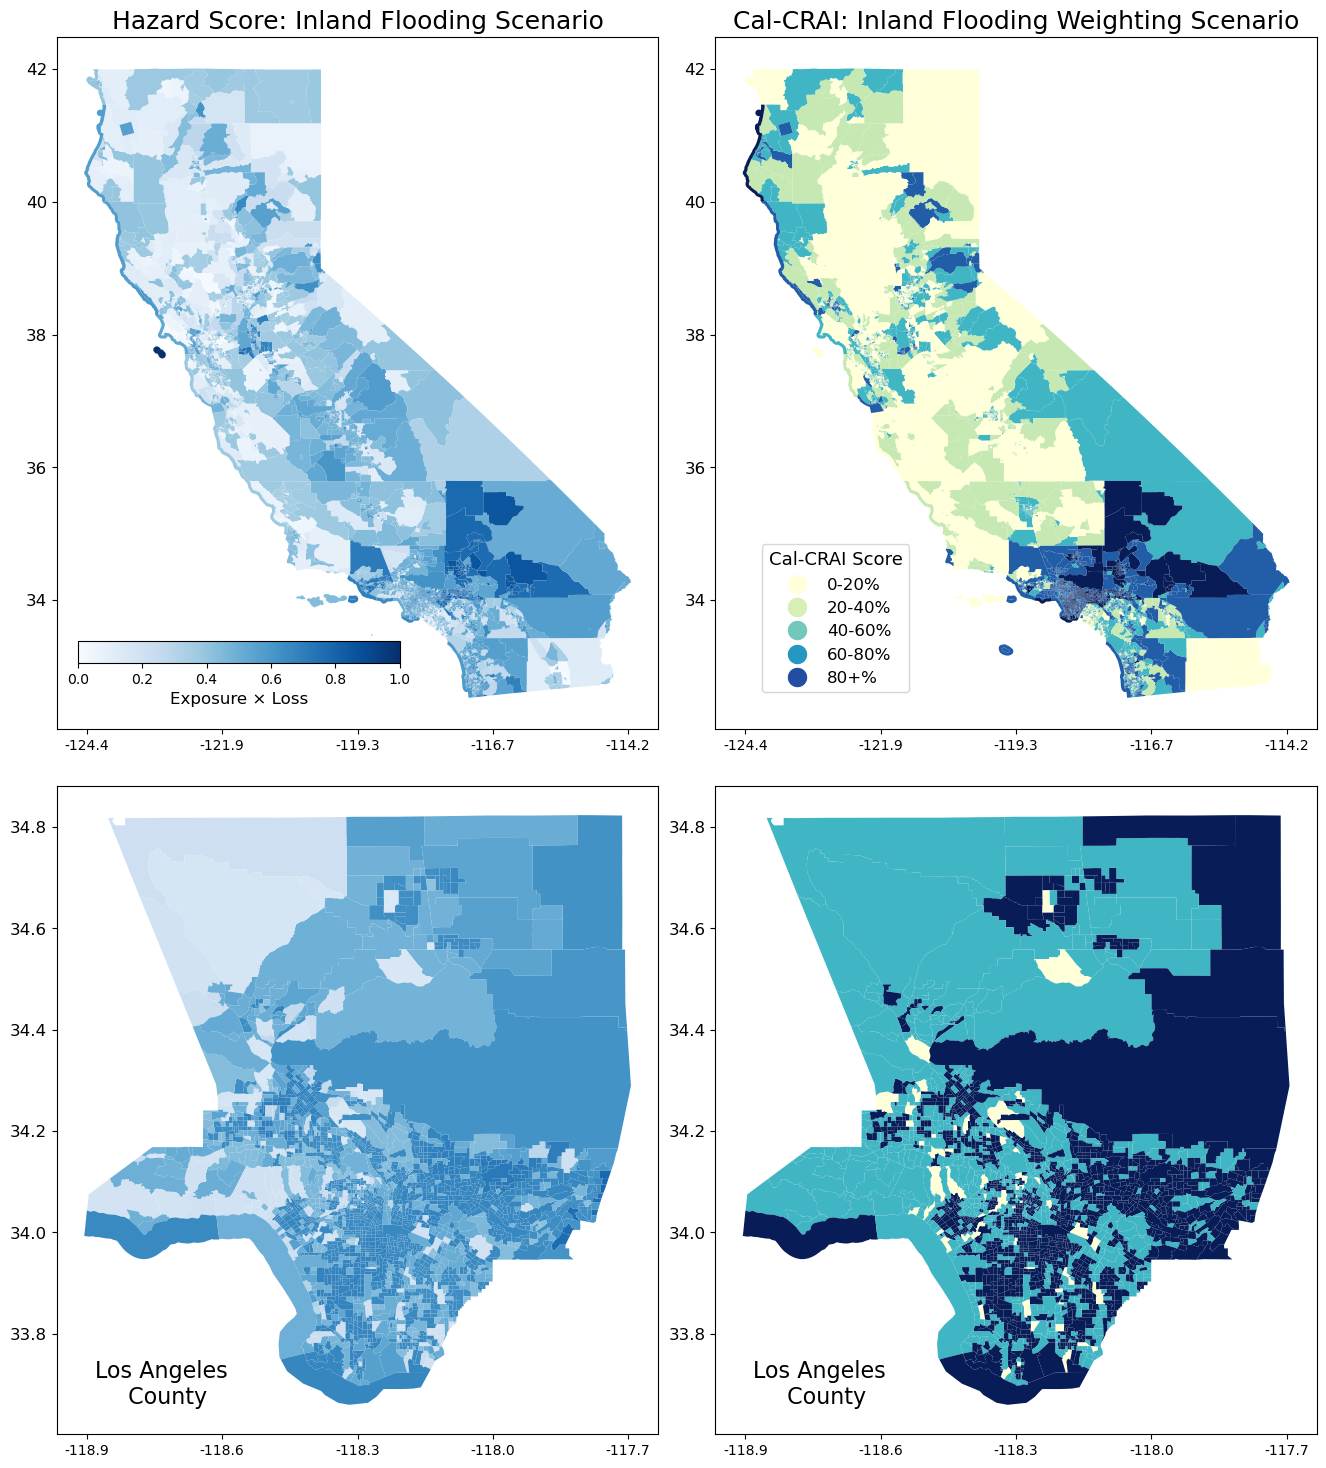

In [81]:
plot_hazard_subplots(merged_inland_flooding_df_ca_boundaries, la_county_inland_flooding, "inland_flooding", "CalCRAI_inland_flooding_subplot.png")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


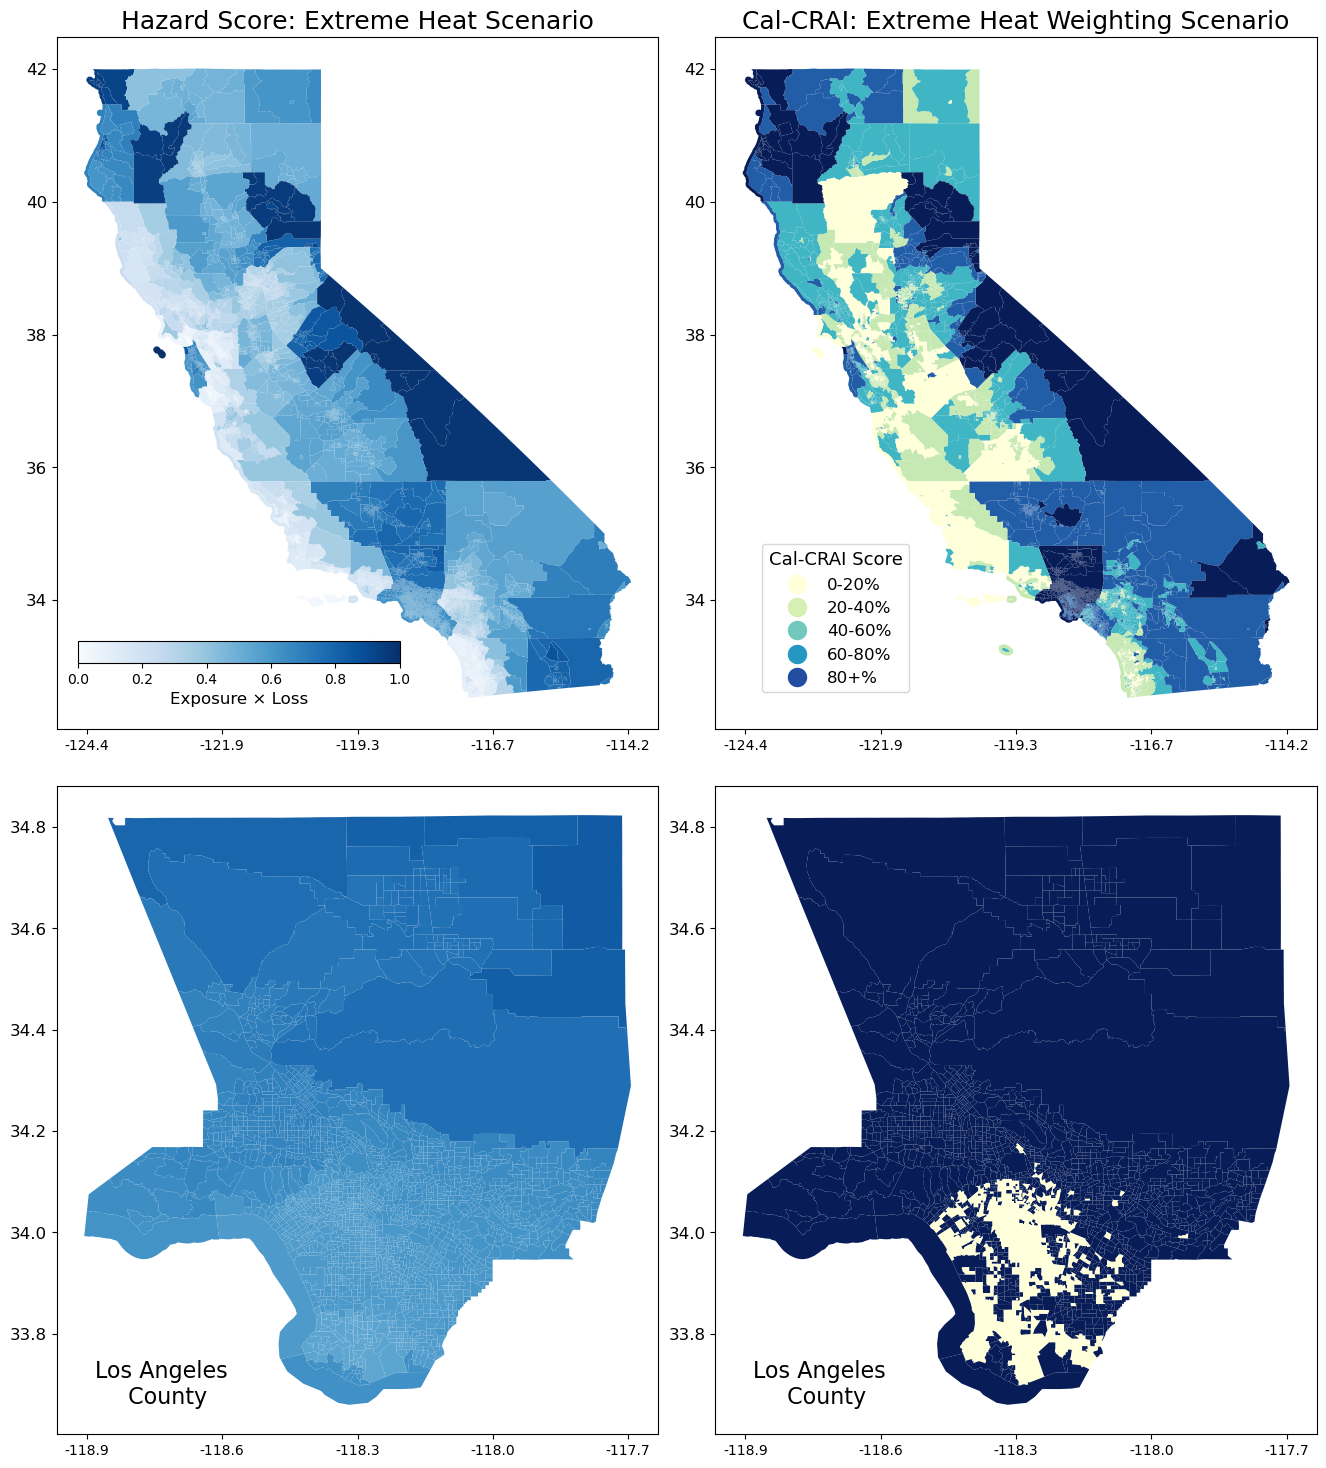

In [80]:
plot_hazard_subplots(merged_extreme_heat_df_ca_boundaries, la_county_extreme_heat, "extreme_heat", "CalCRAI_extreme_heat_subplot.png")

In [87]:
merged_wildfire_df_ca_boundaries.columns

Index(['GEOID', 'wildfire_hazard_score', 'wildfire_scenario_calcrai_score',
       'wildfire_scenario_calcrai_score_quartile',
       'calcrai_wildfire_score_quartile', 'STATEFP', 'COUNTYFP', 'TRACTCE',
       'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'geometry'],
      dtype='object')

In [89]:
merged_wildfire_df_no_geo = merged_wildfire_df_ca_boundaries.drop(columns={'geometry'})

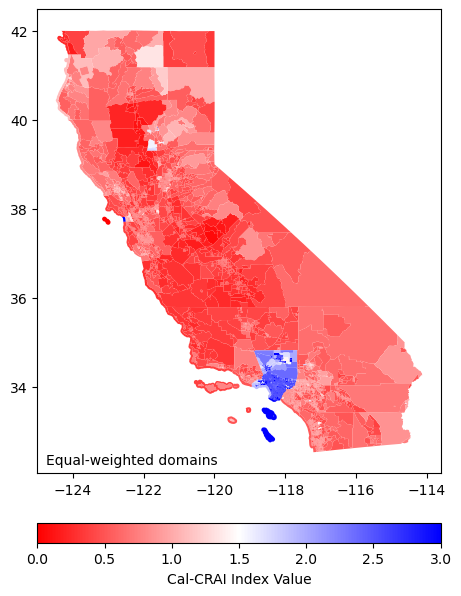

In [90]:
index_plot(merged_wildfire_df_no_geo, column='wildfire_scenario_calcrai_score', vmin=0, vmax=3)

In [92]:
la_county_wildfire.columns

Index(['GEOID', 'wildfire_hazard_score', 'wildfire_scenario_calcrai_score',
       'wildfire_scenario_calcrai_score_quartile',
       'calcrai_wildfire_score_quartile', 'STATEFP', 'COUNTYFP', 'TRACTCE',
       'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT',
       'INTPTLON', 'geometry'],
      dtype='object')

In [91]:
merged_wildfire_df_no_geo_la = la_county_wildfire.drop(columns={'geometry'})

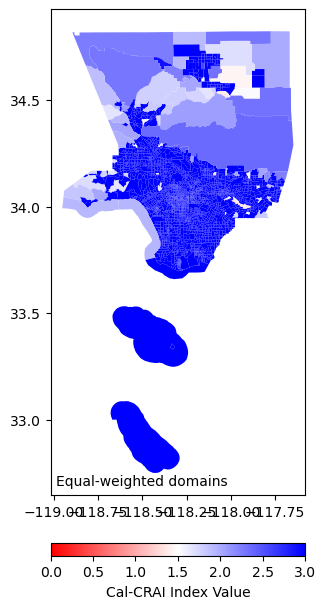

In [93]:
index_plot(merged_wildfire_df_no_geo_la, column='wildfire_scenario_calcrai_score', vmin=0, vmax=3)